Things I've fixed:  

* number of rows - pad at 100



Some timings on the validation data (so multiply by 10)

batch size: 56  
CUDA - CPU times: user 2min 13s, sys: 1.11 s, total: 2min 14s  
CPU - CPU times: user 1min 18s, sys: 3.22 s, total: 1min 21s  

batch size: 128  
CUDA - CPU times: user 1min 31s, sys: 651 ms, total: 1min 32s  
CPU - CPU times: user 1min 18s, sys: 3.22 s, total: 1min 21s  

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import scipy.stats

In [6]:
%matplotlib inline

In [7]:
import sys
sys.path.append('..')
import time

In [8]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.utils import seed_everything
from src.data.data_scaler import PreProcess
from data.feature_sets import all_features

In [9]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [10]:
def pad_numpy(vec, pad):
    pad_size = list(vec.shape)
    pad_size[0] = pad - vec.shape[0]
    return np.concatenate([vec, np.zeros(pad_size)], axis=0)

In [11]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def import_data(path):
    df = pd.read_csv(path)
    ids = df.icustay_id.unique()
    for id_ in ids:
        df_id = df.loc[df.icustay_id == id_,:]
        if (sum(df_id.msk) == df_id.shape[0]):
            df.drop(df.loc[df.icustay_id == id_,:].index,inplace=True)
            print("excluding:",id_)
    return df

TIME_VARS = ["timer","timer_dt"]

def pad_numpy(vec, pad, val="zeros"):
    pad_size = list(vec.shape)
    pad_size[0] = pad - vec.shape[0]
    if val == "zeros":
        out = np.concatenate([vec, np.zeros(pad_size)], axis=0)
    elif val == "ones":
        out = np.concatenate([vec, np.ones(pad_size)], axis=0)
    return out

TIME_VARS = ["timer","timer_dt"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,features,pad=100,maxrows=100,verbose=True):
        self.pad = pad
        self.maxrows = maxrows
        self.X,self.y,self.msk,self.dt,self.seqlen = self.load_data(df,features,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # pad
        X = pad_numpy(self.X[idx],self.pad).astype(np.float32)
        y = pad_numpy(self.y[idx],self.pad).astype(np.float32)
        msk = pad_numpy(self.msk[idx],self.pad,val="ones").astype(np.int32)
        dt = pad_numpy(self.dt[idx],self.pad).astype(np.float32)
        seqlen = self.seqlen[idx]

        return X,y,msk,dt,seqlen
    
    def load_data(self,df,features,verbose):
        excl = []
        n_excl_pt = 0
        n_excl_rws = 0
        X_list, y_list, msk_list, dt_list, seqlen_list = [], [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:].iloc[0:self.maxrows]
            if (sum(df_id.msk) == df_id.shape[0]):
                #print("excluding:",id_)
                n_excl_pt += 1
                n_excl_rws +=  df_id.loc[df_id.msk == 0].shape[0]
                continue
            # additional exclusions
#             if ((max(df_id.timer)/24 > 7.0) or (max(df_id.timer) < 6.0)):
#                 print("excluding (time):",id_)
#                 continue
            n_days_gl = (max(df_id.timer_dt) - min(df_id.timer))/24
            n_gl_meas = df_id.loc[df_id.msk == 0].shape[0]
            if (n_gl_meas/n_days_gl < 1.0):
                n_excl_pt += 1
                n_excl_rws +=  df_id.loc[df_id.msk == 0].shape[0]
                #print("excluding (<1/day):",id_)
                continue
            X = df_id.loc[:,features]
            y = df_id.loc[:,"glc_dt"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            seqlen = df_id.shape[0]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
            seqlen_list.append(seqlen)
        print("excluded patients:",n_excl_pt)
        print("excluded rows:",n_excl_rws)
        return X_list,y_list,msk_list,dt_list,seqlen_list

In [12]:
df = pd.read_csv('../data/train.csv')
train_ids, valid_ids = train_test_split(df.icustay_id.unique(),test_size=0.1)
df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(valid_ids)]
FEATURES = all_features()
NFEATURES = len(all_features())
preproc = PreProcess(FEATURES,QuantileTransformer())
preproc.fit(df_train)
df_train = preproc.transform(df_train)
df_valid = preproc.transform(df_valid)

In [13]:
math.sqrt(np.mean((ginv(df_train.loc[df_train.msk==0,'glc']) - ginv(df_train.loc[df_train.msk==0,'glc_dt']))**2))

42.8632813011104

In [14]:
math.sqrt(np.mean((ginv(df_valid.loc[df_valid.msk==0,'glc']) - ginv(df_valid.loc[df_valid.msk==0,'glc_dt']))**2))

43.50852589919706

In [15]:
dl_train = DataLoader(MIMICDataset(df_train,FEATURES),batch_size=128,pin_memory=False)
dl_valid = DataLoader(MIMICDataset(df_valid,FEATURES),batch_size=128,pin_memory=False)
dataloaders = {'train':dl_train,'validation':dl_valid}

reconfiguring data...
excluded patients: 235
excluded rows: 659
reconfiguring data...
excluded patients: 16
excluded rows: 43


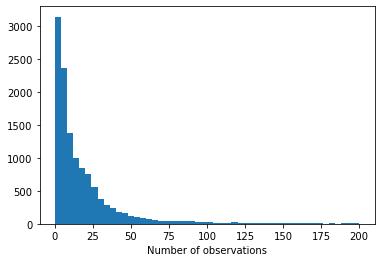

In [12]:
plt.hist(df.groupby(['icustay_id']).size(),range=[0,200],bins=50)
plt.xlabel('Number of observations')
plt.show()

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim):
        loss = 0.0
        n_batches = len(dataloader)
        print("number of batchs: {}".format(n_batches))
        for i, (x, y, msk, dt, seqlen) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x).squeeze(2)
            loss_step = self.loss_fn(preds,y,~msk.squeeze(0))
            loss_step.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)
            optim.step()
            loss += loss_step.item()
            if i % int(n_batches/4) == 0:
                print("Batch number: {}".format(i))
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        # batch size should be 1
        
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt,seqlen) in enumerate(dataloader):
                N += sum(sum(msk == 0)).item()
                x = x.to(self.device)
                y = y.to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x).squeeze(2)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.squeeze(0)).item()
                loss += self.loss_fn(y_,y,~msk.squeeze(0)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [46]:
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,device):
        super(ODEFunc, self).__init__()
        
        self.x = torch.zeros(128,100,6).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),2)
        out = self.net(xz)
        out = out * (self.dt/100) # -> scale by timestep
        return out 
    
    def solve_ode(self, x0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, x0, torch.tensor([0,1.0]).to(self.device),rtol=1e-3, atol=1e-3)[1]
        return outputs
    
class neuralODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim,device).to(device)
        
    def forward(self, dt, x, seqlen=0):
        
        #x = x.squeeze(0)
        #dt = dt.squeeze(0)
        T = x.size(1)
        
        # ODE
        mu_out = torch.zeros(x.size(0),T,1,device = self.device)
        for i in range(0,T):
            y0 = x[:,i:(i+1),0:1]
            x_i = x[:,i:(i+1),1:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            mu_out[:,i:(i+1),:] = self.func.solve_ode(y0,dt_i,x_i)

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [39]:
#dl_train = DataLoader(MIMICDataset(df_train,FEATURES),batch_size=2,pin_memory=True)

In [64]:
nepochs = 2
n_ode = neuralODE(NFEATURES,1,0.0,1,"cuda").to("cuda")
model_optim = optim.Adam(n_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    n_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print(elapsed_time)

EPOCH: 0
number of batchs: 86
Batch number: 0
BATCH_loss : 0.090
Batch number: 21
BATCH_loss : 0.070
Batch number: 42
BATCH_loss : 0.077
Batch number: 63
BATCH_loss : 0.070
Batch number: 84
BATCH_loss : 0.077
EPOCH_loss : 0.073
EPOCH: 1
number of batchs: 86
Batch number: 0
BATCH_loss : 0.084
Batch number: 21
BATCH_loss : 0.068
Batch number: 42
BATCH_loss : 0.076
Batch number: 63
BATCH_loss : 0.068
Batch number: 84
BATCH_loss : 0.076
EPOCH_loss : 0.071
256.4110782146454


In [ ]:
# evaluate - averages

In [65]:
loss,rmse, y_preds, y_tests, msks = n_ode.evaluate(dl_valid)
print(rmse)
print(loss)

y_preds = (np.concatenate(y_preds))
y_tests = (np.concatenate(y_tests))
msk = (np.concatenate(msks))

diff = y_preds - y_tests
print(np.mean(diff[~msk]**2))
print(np.std(y_tests[~msk]))

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

_rmse : 42.164
_loss : 0.069
42.16436924932725
0.06897715628147125
0.06976147
0.3493343


In [ ]:
plt.hist(y_tests[~msk],bins=20)
plt.show()
plt.hist(y_preds[~msk],bins=20)
plt.show()

In [ ]:
plt.scatter(y_preds[~msk],y_tests[~msk])
plt.show()
c = np.log(140)
plt.scatter(ginv(y_preds[~msk]),ginv(y_tests[~msk]))
plt.show()

In [ ]:
N = 20
res = np.zeros(N)
Y0 = torch.linspace(-1.0,1.0,N)
y0 = torch.zeros(1,1,1)
dt = torch.ones(1,1,1).to("cuda")
n_ode.func.x = torch.zeros(1,1,1).to("cuda")
n_ode.func.dt = dt
for i in range(0,N):
    y0[0,0,0] = Y0[i]
    with torch.no_grad():
        res[i] = n_ode.func(dt,y0.to("cuda")).cpu().numpy().item()

In [ ]:
Y0 = Y0.cpu().numpy()
plt.scatter(Y0,res)

In [ ]:
plt.scatter(Y0,Y0 + res)

In [ ]:
ts = np.linspace(0,1,10)
fig, ax = plt.subplots(1, 1, tight_layout=True)
for t in ts:
    for i in range(N):
        dy =  np.exp(Y0[i]+res[i]+np.log(140)) - np.exp(Y0[i]+np.log(140))
        ax.arrow(t,np.exp(Y0[i]+np.log(140)),0.09,dy, width = 0.008)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Blood glucose (mg/dL)")
fig.savefig('tmp.jpg', bbox_inches='tight', dpi=150)

In [ ]:
####################################################################################################

In [71]:
class LODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,hidden_dim,input_dim,device):
        super(LODEFunc, self).__init__()

        self.x = torch.zeros(128,100,input_dim).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, hidden_dim * 2),
            nn.Tanh(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),2)
        out = self.net(xz)
        out = out * (self.dt/100) # -> scale by timestep
        return out 

    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1)[1]
        return outputs
    
class latentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = LODEFunc(hidden_dim,input_dim,device).to(device)
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        ).to(device)
        self.encode_z0 = nn.Sequential(
            nn.Linear(input_dim, max(hidden_dim,hidden_dim) // 2),
            nn.Tanh(),
            nn.Linear(max(hidden_dim,hidden_dim) // 2, hidden_dim),
            nn.Tanh(),
        ).to(device)
        
        for m in self.encode_z0.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        
    def forward(self, dt, x, seqlen=0):
        
        #x = x.squeeze(0)
        batch_size = x.size(0)
        T = x.size(1)
        
        # ODE
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        #z0 = 0.01 * torch.randn(batch_size,1,self.hidden_dim,device = self.device)
        z0 = self.encode_z0(x[:,0,:]).unsqueeze(1)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            z0 = self.func.solve_ode(z0,dt_i,x_i)
            mu_out[:,i:(i+1),:] = self.mu_net(z0.squeeze(1)).unsqueeze(1)

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [72]:
l_ode = latentODE(NFEATURES,8,0.0,1,"cuda").to("cuda")
x,y,msk,dt,_ = next(iter(dl_train))
y_ = l_ode(dt.to("cuda"),x.to("cuda"))
print(y_.shape)
loss = l_ode.loss_fn(y.to("cuda"),y_.squeeze(2),~msk.bool().to("cuda").squeeze(0))
print(loss)
loss.backward()

torch.Size([128, 100, 1])
tensor(0.1486, device='cuda:0', grad_fn=<MeanBackward0>)


In [73]:
nepochs = 5
l_ode = latentODE(NFEATURES,10,0.1,1,"cuda")
model_optim = optim.Adam(l_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    l_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

EPOCH: 0
number of batchs: 86
Batch number: 0
BATCH_loss : 0.238
Batch number: 21
BATCH_loss : 0.112
Batch number: 42
BATCH_loss : 0.101
Batch number: 63
BATCH_loss : 0.107
Batch number: 84
BATCH_loss : 0.104
EPOCH_loss : 0.108
EPOCH: 1
number of batchs: 86
Batch number: 0
BATCH_loss : 0.098
Batch number: 21
BATCH_loss : 0.081
Batch number: 42
BATCH_loss : 0.082
Batch number: 63
BATCH_loss : 0.092
Batch number: 84
BATCH_loss : 0.099
EPOCH_loss : 0.087
EPOCH: 2
number of batchs: 86
Batch number: 0
BATCH_loss : 0.097
Batch number: 21
BATCH_loss : 0.078
Batch number: 42
BATCH_loss : 0.077
Batch number: 63
BATCH_loss : 0.085
Batch number: 84
BATCH_loss : 0.092
EPOCH_loss : 0.082
EPOCH: 3
number of batchs: 86
Batch number: 0
BATCH_loss : 0.091
Batch number: 21
BATCH_loss : 0.077
Batch number: 42
BATCH_loss : 0.075


KeyboardInterrupt: 

In [69]:
loss,rmse, y_preds, y_tests, msks = l_ode.evaluate(dl_valid)

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

_rmse : 51.927
_loss : 0.090


In [ ]:
y_preds = (np.concatenate(y_preds))
y_tests = (np.concatenate(y_tests))
msk = (np.concatenate(msks))

In [ ]:
plt.scatter(ginv(y_preds[~msk]),ginv(y_tests[~msk]))
plt.show()

In [ ]:
##########################################################################################################

In [ ]:
# linear system of z = (g,h)

In [86]:
 class recurrentODE_(nn.Module):
    """
    (dglucose/dt,dh/dt) = (RNN(glucose,h),NN(h,x))
    """
    def __init__(self,hidden_dim,input_dim,batch_size,device):
        super(recurrentODE_, self).__init__()
        
        self.x = torch.zeros(batch_size,100,input_dim).to(device)
        self.dt = torch.zeros(batch_size,100,1).to(device)
        self.device = device
        # dh/dt
        self.dh = nn.Sequential(
            nn.Linear(hidden_dim+input_dim, (hidden_dim+input_dim)*2),
            nn.ReLU(),
            nn.Linear((hidden_dim+input_dim)*2, hidden_dim),
            nn.Tanh(),
        ).to(device)
        # dy/dt
        self.dy_rnn = nn.RNNCell(input_dim, hidden_dim)
        self.dy_lin = nn.Linear(hidden_dim, 1)
        self.dy_tanh = nn.Tanh()

        for m in self.dh.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        nn.init.normal_(self.dy_rnn.weight_ih,mean=0, std=0.1)
        nn.init.normal_(self.dy_rnn.weight_hh,mean=0, std=0.1)
        nn.init.constant_(self.dy_rnn.bias_ih, val=0)
        nn.init.constant_(self.dy_rnn.bias_ih, val=0)
        nn.init.normal_(self.dy_lin.weight,mean=0, std=0.1)
        nn.init.constant_(self.dy_lin.bias, val=0)

    def forward(self, t, z):
        # dh/dt
        #dh = self.dh(z[:,:,1:])*self.dt
        dh = self.dh(torch.cat((self.x,z[:,:,1:]),2)) * (self.dt / 50)
        # dy/dt
        #dy = self.dy_rnn(self.x.squeeze(1),z[:,:,1:].squeeze(1)) # hidden should be shape (1,batch,hidden)
        #dy = self.dy_lin(dy.unsqueeze(1))
        dy = self.dy_lin(z[:,:,1:])
        dy = self.dy_tanh(dy) * (self.dt / 50)
        return torch.cat((dy,dh),2)
    
    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1)[1]
        return outputs
    
class recurrentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim,batch_size, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.batch_size = batch_size
        self.func = recurrentODE_(hidden_dim,input_dim,batch_size,device).to(device)
        
    def forward(self, dt, x, seqlen=0):
        
        #x = x.squeeze(0)
        batch_size = x.size(0)
        T = x.size(1)

        # ODE stuff
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        z0 = torch.zeros(batch_size,1,self.hidden_dim+1,device = self.device)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            y0 = x[:,i:(i+1),0:1]
            z0[:,:,0:1] = y0
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            z0 = self.func.solve_ode(z0,dt_i,x_i)
            mu_out[:,i:(i+1),:] = z0[:,:,0:1]

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [89]:
nepochs = 5
batch_size = 128
r_ode = recurrentODE(NFEATURES,4,0.0,1,batch_size,"cuda").to("cuda")
model_optim = optim.Adam(r_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    r_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

EPOCH: 0
number of batchs: 86
Batch number: 0
BATCH_loss : 0.090
Batch number: 21
BATCH_loss : 0.072
Batch number: 42
BATCH_loss : 0.082
Batch number: 63
BATCH_loss : 0.074
Batch number: 84
BATCH_loss : 0.082
EPOCH_loss : 0.076
EPOCH: 1
number of batchs: 86
Batch number: 0
BATCH_loss : 0.090
Batch number: 21
BATCH_loss : 0.072
Batch number: 42
BATCH_loss : 0.082
Batch number: 63
BATCH_loss : 0.074
Batch number: 84
BATCH_loss : 0.081
EPOCH_loss : 0.076
EPOCH: 2
number of batchs: 86
Batch number: 0
BATCH_loss : 0.090
Batch number: 21
BATCH_loss : 0.072
Batch number: 42
BATCH_loss : 0.082


KeyboardInterrupt: 

In [90]:
loss,rmse, y_preds, y_tests, msks = r_ode.evaluate(dl_valid)

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

_rmse : 43.812
_loss : 0.074


In [ ]:
_rmse : 41.815
_loss : 0.068

In [ ]:
#################################################################################

In [ ]:
# ODE-RNN

In [ ]:
class ODERNN_(nn.Module):
    """
    In an ODE-RNN the hidden state h_t of the RNN evolves according to
    an ODE. This ODE is a neural network, i.e. dh/dt = ODEFunc(h,x).
    """
    def __init__(self,hidden_dim,device):
        super(ODERNN_, self).__init__()

        self.x = torch.zeros(128,100,6).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, dt, y):
        out = self.net(y)
        out = out * (self.dt / 100)
        return out
    
    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1)[1]
        return outputs

class ODERNN(Baseline):
    """
    ODE-RNN
    """
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        # ODE-RNN
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.func = ODERNN_(hidden_dim,device)
        # N(mu,sigma)
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(hidden_dim,hidden_dim//2)
        self.distribution_mu = nn.Linear(hidden_dim//2, 1)

    def forward(self, dt, x, p=0.0):
        
        T = x.size(1)

        batch_size = x.size(0)
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        h_t = torch.zeros(batch_size, self.rnn.hidden_size,device=self.device)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1)
            h_t = self.rnn(x_i.squeeze(1),h_t)
            h_t = self.func.solve_ode(h_t,dt_i,x_i)
            mu = self.l1(h_t)
            mu = F.dropout(mu,training=True,p=p)
            mu = self.relu(mu)
            mu_out[:,i:(i+1),:] = self.distribution_mu(mu).unsqueeze(1)

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [ ]:
nepochs = 5
rnn_ode = ODERNN(NFEATURES,6,0.1,1,"cuda").to("cuda")
model_optim = optim.Adam(rnn_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    rnn_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

In [ ]:
loss,rmse, y_preds, y_tests, msks = rnn_ode.evaluate(dl_valid)

In [ ]:
_rmse : 43.876
_loss : 0.062

_rmse : 53.869
_loss : 0.092

In [21]:
x,y,msk,dt,_ = next(iter(dl_train))

(array([67.,  9., 37.,  4.,  5.,  1.,  0.,  4.,  0.,  1.]),
 array([0.        , 0.04828   , 0.09655999, 0.14483999, 0.19311999,
        0.24139999, 0.28967997, 0.33795998, 0.38623998, 0.43451998,
        0.48279998], dtype=float32),
 <BarContainer object of 10 artists>)

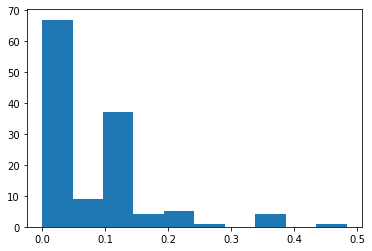

In [32]:
plt.hist((dt[:,3,:][:,1] - dt[:,3,:][:,0]).unsqueeze(1).numpy()/50)

In [33]:
1/50

0.02